In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [15]:
import torch
from os import environ
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from hydra import compose, initialize
from hydra.utils import instantiate

from bliss.catalog import TileCatalog, FullCatalog
from bliss.encoder.plotting import plot_plocs

In [16]:
# set bliss home directory and load config
environ["BLISS_HOME"] = "~/bliss"
with initialize(config_path="../../bliss/conf", version_base=None):
    cfg = compose("aakash")

## Test generating a batch

In [6]:
simulator = instantiate(cfg.simulator)

In [7]:
batch = simulator.get_batch()

In [9]:
full_cat = TileCatalog(4, batch["tile_catalog"]).to_full_catalog()
full_cat.plocs.shape

torch.Size([4, 20, 2])

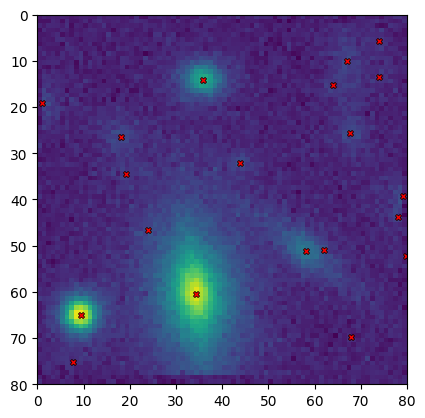

In [11]:
ax = plt.gca()

ax.imshow(batch["images"][0, 2].log(), extent=(0, 80, 80, 0))
plot_plocs(full_cat, ax, 0, s=20, marker="X", c="r", edgecolor="k", linewidth=0.5)

## View HLR distribution

In [17]:
with open("/data/scratch/aakash/single_field_train/dataset_0.pt", "rb") as f:
    data = torch.load(f)

In [18]:
dataloader = torch.utils.data.DataLoader(data, batch_size=4)
batch = next(iter(dataloader))

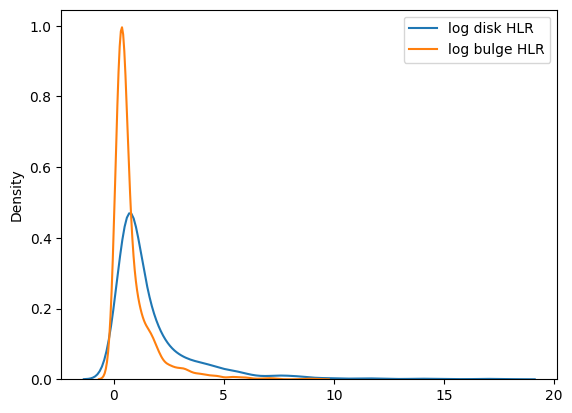

In [19]:
disk_hlr = batch["tile_catalog"]["galaxy_params"][..., 6].flatten().numpy()
bulge_hlr = batch["tile_catalog"]["galaxy_params"][..., 7].flatten().numpy()

ax = plt.gca()
sns.kdeplot(disk_hlr, ax=ax, label="log disk HLR")
sns.kdeplot(bulge_hlr, ax=ax, label="log bulge HLR")
ax.legend()
# ax.hist(np.log(disk_hlr), bins=20, alpha=0.8);
# ax.hist(np.log(bulge_hlr), bins=20, alpha=0.8);

approximately log normal

## Test train with HLR in variational dist

In [5]:
encoder = instantiate(cfg.encoder)

In [12]:
loss = encoder.training_step(batch, 0)

/home/aakashdp/.cache/pypoetry/virtualenvs/bliss-deblender-av05Bskt-py3.10/lib/python3.10/site-packages/pytorch_lightning/core/module.py:411: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


In [13]:
loss

tensor(1.2151, grad_fn=<DivBackward0>)

In [14]:
encoder.update_metrics(batch)
encoder.report_metrics("train")